Notebook to visualise MAG abundances in metagenomes based on read mapping with BBMap (bbsplit.sh) (Bushnell 2014) and summarise MAG statistics. Uses output from MetaSing inluding:
- taxonomy identified by GTDB-tk (Chaumeil et al. 2021)
- dRep (Olm et al. 2017)

<br>
References:
<br>
Olm, M. R., Brown, C. T., Brooks, B., & Banfield, J. F. (2017). dRep: a tool for fast and accurate genomic comparisons that enables improved genome recovery from metagenomes through de-replication. The ISME journal, 11(12), 2864-2868.
<br>
Chaumeil, P. A., Mussig, A. J., Hugenholtz, P., & Parks, D. H. (2020). GTDB-Tk: a toolkit to classify genomes with the Genome Taxonomy Database.

In [1]:
from Bio import SeqIO
import os
import fnmatch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
import matplotlib
import matplotlib.patches as mpatches
from matplotlib import colors
from matplotlib.colors import ListedColormap
from itertools import islice, cycle


In [2]:
print('\n'.join(f'{m.__name__}=={m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))

numpy==1.21.1
pandas==1.3.1
seaborn==0.11.2
matplotlib==3.4.2


In [3]:
# Manually renamed files from 1,2, etc. to the original sample names (see log_file.txt)
# Produce a dataframe from all covstats files
base_dir = "/Users/vincentn/Documents/Sequencing/Sponge_paper_reads_to_dRep_bins_131022_covstats/"
cov_list = []
cov_cols=["#ID","Avg_fold","Covered_percent"]
count=0

for covstat in os.listdir(base_dir):
    if fnmatch.fnmatch(covstat, '*covstats.tsv'):
        sname = covstat.split("_")[0]
        df = pd.read_csv(os.path.join(base_dir,covstat),sep='\t',usecols=cov_cols)
        df['sample'] = sname
        print("df for "+ str(sname) + " is " + str(len(df)) + " lines long")
        cov_list.append(df)
        
cov_df = pd.concat(cov_list, axis=0, ignore_index=True)
print("The final cov_df is " + str(len(cov_df)) + " lines long")
print(cov_df.head())

df for MHs5 is 158990 lines long
df for MHs2 is 158990 lines long
df for CS202 is 158990 lines long
df for 0977 is 158990 lines long
df for MHs3 is 158990 lines long
df for AplysinaMBB is 158990 lines long
df for Petrosia is 158990 lines long
df for CS204 is 158990 lines long
df for CS203 is 158990 lines long
df for CS211 is 158990 lines long
df for AplysinaPFT is 158990 lines long
df for Sarcotragus is 158990 lines long
df for AplysinaPPK is 158990 lines long
df for 7375 is 158990 lines long
df for AplysinaMFT is 158990 lines long
df for AplysinaMPK is 158990 lines long
df for MHs1 is 158990 lines long
df for MHpat150 is 158990 lines long
df for AplysinaPBB is 158990 lines long
df for CS783 is 158990 lines long
df for CS200 is 158990 lines long
The final cov_df is 3338790 lines long
                                                 #ID  Avg_fold  \
0  0977_bin.100.fa.metabat2$NODE_19_length_474527...       0.0   
1  0977_bin.100.fa.metabat2$NODE_47_length_313761...       0.0   
2  0977

In [4]:
# NEED to change the #ID column in order to merge by contig later
# Informtion on which sample the bin came from originally is saved in the 'bin_sample' column
# This is slow
count = 0
for i in cov_df["#ID"]:
    cov_df.at[count, '#ID'] = i.split('$')[1]
    cov_df.at[count, 'bin_sample'] = i.split('$')[0]
    count += 1

In [5]:
print("There are " + str(len(cov_df['sample'].unique())) + " samples in the cov_df")
print("There are " + str(len(cov_df['bin_sample'].unique())) + " bins in the cov_df")
print(str(len(cov_df[cov_df["Avg_fold"] == 0])) + " contigs out of " + str(len(cov_df)) + " have Avg_fold coverage of 0")
print(str(len(cov_df[cov_df["Avg_fold"] < 1])) + " contigs out of " + str(len(cov_df)) + " have Avg_fold coverage of < 1")
print(str(len(cov_df[cov_df["Avg_fold"] >= 1])) + " contigs out of " + str(len(cov_df)) + " have Avg_fold coverage of >= 1")
cov_df.head()

There are 21 samples in the cov_df
There are 510 bins in the cov_df
2708579 contigs out of 3338790 have Avg_fold coverage of 0
2994387 contigs out of 3338790 have Avg_fold coverage of < 1
344403 contigs out of 3338790 have Avg_fold coverage of >= 1


,#ID,Avg_fold,Covered_percent,sample,bin_sample
0,NODE_19_length_474527_cov_12.465114,0.0,0.0,MHs5,0977_bin.100.fa.metabat2
1,NODE_47_length_313761_cov_12.317858,0.0,0.0,MHs5,0977_bin.100.fa.metabat2
2,NODE_52_length_296533_cov_14.152666,0.0,0.0,MHs5,0977_bin.100.fa.metabat2
3,NODE_78_length_242904_cov_12.746710,0.0,0.0,MHs5,0977_bin.100.fa.metabat2
4,NODE_87_length_231793_cov_13.616297,0.0,0.0,MHs5,0977_bin.100.fa.metabat2


In [6]:
# Subsampling only contigs that are covered by more than 75%
print(len(cov_df[cov_df['Covered_percent'] >= 75.0]))
cov_75_df = cov_df[cov_df['Covered_percent'] >= 75.0]
print(len(cov_75_df))

266798
266798


In [7]:
# Calculate the mean coverage for each bin in each sample
cov_75_df_summary = cov_75_df.groupby(["bin_sample", "sample"], as_index=False)["Avg_fold"].mean()
print(len(cov_75_df_summary))
cov_75_df_summary.head()

1844


,bin_sample,sample,Avg_fold
0,0977_bin.1.fa.maxbin2,0977,809.965614
1,0977_bin.1.fa.maxbin2,7375,5.685300
2,0977_bin.10.fa.metabat2,0977,6.752876
3,0977_bin.10.fa.metabat2,7375,144.621233
4,0977_bin.10.fa.metabat2,MHs1,83.379733


In [8]:
# Make a copy of the 75 covered percent filtered summary df and normalise based on total coverage within each sample
norm_cov_75_df = cov_75_df_summary.copy()
print(norm_cov_75_df['sample'].unique())
groups = norm_cov_75_df.groupby('sample')
norm_cov_75_df['Avg_fold'] = groups['Avg_fold'].transform(lambda x: (x / x.sum()))
norm_cov_75_df

['0977' '7375' 'MHs1' 'MHs2' 'MHs3' 'MHs5' 'MHpat150' 'AplysinaMFT'
 'AplysinaMPK' 'AplysinaPBB' 'AplysinaPPK' 'Petrosia' 'AplysinaMBB'
 'AplysinaPFT' 'Sarcotragus' 'CS202' 'CS203' 'CS204' 'CS211' 'CS783'
 'CS200']


,bin_sample,sample,Avg_fold
0,0977_bin.1.fa.maxbin2,0977,0.104139
1,0977_bin.1.fa.maxbin2,7375,0.001353
2,0977_bin.10.fa.metabat2,0977,0.000868
3,0977_bin.10.fa.metabat2,7375,0.034408
4,0977_bin.10.fa.metabat2,MHs1,0.012444
...,...,...,...
1839,Sarcotragus_cluster_DBSCAN_round6_6,AplysinaMPK,0.033478
1840,Sarcotragus_cluster_DBSCAN_round6_6,AplysinaPBB,0.075891
1841,Sarcotragus_cluster_DBSCAN_round6_6,AplysinaPFT,0.049788
1842,Sarcotragus_cluster_DBSCAN_round6_6,AplysinaPPK,0.038402


In [9]:
print("There are " + str(len(norm_cov_75_df['bin_sample'].unique())) + " bins in the norm_cov_75_df")
print("There were " + str(len(cov_df['bin_sample'].unique())) + " bins in the cov_df")
print("There were " + str(len(cov_75_df['bin_sample'].unique())) + " bins in the cov_75_df")
print("No bins were lost! WOHOO!")

There are 510 bins in the norm_cov_75_df
There were 510 bins in the cov_df
There were 510 bins in the cov_75_df
No bins were lost! WOHOO!


In [10]:
# Sanity check the relative abundances add up to 1 for each sample
norm_cov_75_df.groupby('sample').sum()

,Avg_fold
sample,
0977,1.0
7375,1.0
AplysinaMBB,1.0
AplysinaMFT,1.0
AplysinaMPK,1.0
AplysinaPBB,1.0
AplysinaPFT,1.0
AplysinaPPK,1.0
CS200,1.0


In [11]:
# Create a pivot table of the dataframe to show the abundance of each bin per sample in format for heatmap
cluster = norm_cov_75_df[["bin_sample", "sample", "Avg_fold"]].copy()
cluster_pivo = cluster.pivot(index='bin_sample', columns="sample", values='Avg_fold')
cluster_pivo[cluster_pivo.isna() == True] = 0
cluster_pivo.head()

sample,0977,7375,AplysinaMBB,AplysinaMFT,AplysinaMPK,AplysinaPBB,AplysinaPFT,AplysinaPPK,CS200,CS202,...,CS204,CS211,CS783,MHpat150,MHs1,MHs2,MHs3,MHs5,Petrosia,Sarcotragus
bin_sample,,,,,,,,,,,,,,,,,,,,,
0977_bin.1.fa.maxbin2,0.104139,0.001353,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.000000,0.0,0.0
0977_bin.10.fa.metabat2,0.000868,0.034408,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.012444,0.014362,0.00702,0.004038,0.0,0.0
0977_bin.100.fa.metabat2,0.011027,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.000000,0.0,0.0
0977_bin.101.fa.metabat2,0.062529,0.000541,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.000000,0.0,0.0
0977_bin.103.fa.metabat2,0.003346,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.000000,0.0,0.0


In [12]:
#NEED TO SUMMARISE THE ABUNDANCES OF Aplysina into one sample and redraw graph
cluster_pivo_Aall = cluster_pivo.copy()
cluster_pivo_Aall["Aplysina"] = cluster_pivo_Aall[["AplysinaMBB", "AplysinaMFT", "AplysinaMPK", "AplysinaPBB", "AplysinaPFT", "AplysinaPPK"]].mean(axis=1)

In [13]:
# Delete old Aplysina columns
cluster_pivo_Aall = cluster_pivo_Aall.drop(columns=["AplysinaMBB", "AplysinaMFT", "AplysinaMPK", "AplysinaPBB", "AplysinaPFT", "AplysinaPPK"])

In [14]:
# Make a copy of the pivot table and set all abundances less than 0.01 (1%) to 0
cluster_pivo_Aall_excl_low = cluster_pivo_Aall.copy()
cluster_pivo_Aall_excl_low[cluster_pivo_Aall_excl_low<0.01] = 0.0
print(len(cluster_pivo_Aall_excl_low[(cluster_pivo_Aall_excl_low.T != 0).any()]))
cluster_pivo_Aall_excl_low.head()

201


sample,0977,7375,CS200,CS202,CS203,CS204,CS211,CS783,MHpat150,MHs1,MHs2,MHs3,MHs5,Petrosia,Sarcotragus,Aplysina
bin_sample,,,,,,,,,,,,,,,,
0977_bin.1.fa.maxbin2,0.104139,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
0977_bin.10.fa.metabat2,0.000000,0.034408,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.012444,0.014362,0.0,0.0,0.0,0.0,0.0
0977_bin.100.fa.metabat2,0.011027,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
0977_bin.101.fa.metabat2,0.062529,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
0977_bin.103.fa.metabat2,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


In [15]:
# Subsampling to only use the 25 most abundant genomes
# REMEMBER, clustering based in this is inaccurate!
# Calculates the average abundance of all (non-low abundance) MAGs across all samples
abund_25 = cluster_pivo_Aall_excl_low.copy()
abund_25 = abund_25[(abund_25.T != 0).any()]
abund_25["average_abund"] = abund_25[(abund_25.T != 0).any()].sum(axis=1)/len(abund_25.columns)
#abund_25.sort_values(by=["average_abund"])
abund_25 = abund_25.nlargest(25, "average_abund")
abund_25

sample,0977,7375,CS200,CS202,CS203,CS204,CS211,CS783,MHpat150,MHs1,MHs2,MHs3,MHs5,Petrosia,Sarcotragus,Aplysina,average_abund
bin_sample,,,,,,,,,,,,,,,,,
Petrosia_bin.0.fa.maxbin2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.145962,0.207432,0.185495,0.387229,0.098040,0.078734,0.012814,0.044347,0.072503
7375_bin.0.fa.maxbin2,0.000000,0.342837,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.186034,0.231721,0.127138,0.124992,0.000000,0.000000,0.000000,0.063295
CS202_bin.90.fa.maxbin2,0.000000,0.000000,0.000000,0.166383,0.125346,0.118275,0.000000,0.452464,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.053904
0977_bin.12.fa.maxbin2,0.039408,0.019151,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.226958,0.251353,0.130970,0.157489,0.000000,0.000000,0.000000,0.051583
MHpat150_bin.0.fa.maxbin2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.147219,0.167029,0.135165,0.027232,0.340289,0.000000,0.000000,0.000000,0.051058
CS200_cluster_DBSCAN_round3775_2397,0.000000,0.000000,0.750183,0.000000,0.016467,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.047916
MHpat150_bin.15.fa.maxbin2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.029433,0.071359,0.013094,0.184550,0.154209,0.000000,0.000000,0.000000,0.028290
CS202_cluster_DBSCAN_round5_15,0.000000,0.000000,0.000000,0.308888,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.019305
MHs1_bin.2.fa.maxbin2,0.000000,0.072121,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.101900,0.030213,0.033179,0.019128,0.010226,0.000000,0.000000,0.000000,0.016673


In [16]:
# import GTDB-tk dataframes for bac and ar for each sample, add sample_id as in dRep bins
# concatenate into motherframe
# NOTE that there is an old Aplysina file with 66(65) lines, should be 80(79)!!!
gtdb_dir = "/Users/vincentn/Documents/Sequencing/Sponge_paper_sample_vs_abundance_250820/gtdbtk_summary_260820/"
gtdb_list = []
for filename in os.listdir(gtdb_dir):
    if fnmatch.fnmatch(filename, '*.tsv'):
        print(filename)
        sname = filename.split("_")[0]
        df = pd.read_csv(os.path.join(gtdb_dir,filename),sep='\t')
        index_count = 0
        for i in df["user_genome"]:
            df.at[index_count, "user_genome"] = str(sname)+str("_")+str(df.at[index_count, "user_genome"])
            index_count += 1
        #df['sample'] = sname
        print("df for "+ str(sname) + " is " + str(len(df)) + " lines long")
        gtdb_list.append(df)
        
gtdb_df = pd.concat(gtdb_list, axis=0, ignore_index=True)

CS211_gtdbtk.ar122.summary.tsv
df for CS211 is 2 lines long
0977_gtdbtk.bac120.summary.tsv
df for 0977 is 65 lines long
MHs1_gtdbtk.bac120.summary.tsv
df for MHs1 is 7 lines long
Aplysina_gtdbtk.ar122.summary.tsv
df for Aplysina is 1 lines long
CS202_gtdbtk.bac120.summary.tsv
df for CS202 is 54 lines long
0977_gtdbtk.ar122.summary.tsv
df for 0977 is 1 lines long
CS203_gtdbtk.ar122.summary.tsv
df for CS203 is 1 lines long
MHpat150_gtdbtk.bac120.summary.tsv
df for MHpat150 is 20 lines long
CS202_gtdbtk.ar122.summary.tsv
df for CS202 is 1 lines long
Sarcotragus_gtdbtk.bac120.summary.tsv
df for Sarcotragus is 43 lines long
MHs3_gtdbtk.bac120.summary.tsv
df for MHs3 is 12 lines long
CS200_gtdbtk.bac120.summary.tsv
df for CS200 is 78 lines long
MHpat150_gtdbtk.ar122.summary.tsv
df for MHpat150 is 1 lines long
CS783_gtdbtk.bac120.summary.tsv
df for CS783 is 42 lines long
CS204_gtdbtk.ar122.summary.tsv
df for CS204 is 2 lines long
MHs5_gtdbtk.bac120.summary.tsv
df for MHs5 is 5 lines long
CS20

In [17]:
# Creation of phylum strip as in:
# https://github.com/Mattstorey/MH_sponge/blob/master/MH_phylo/Bins_abund_tab/phlyo_strip_2_tax.ipynb

# Extract bin name and classification only
gtdb_df = gtdb_df[['user_genome', 'classification']].reset_index()

# Reformat classification
gtdb_df['phylum'] = gtdb_df['classification'].apply(lambda tax: tax.split(';')[1].split('p__')[1])
gtdb_df['class'] = gtdb_df['classification'].apply(lambda tax: tax.split(';')[2].split('c__')[1])
gtdb_df['order'] = gtdb_df['classification'].apply(lambda tax: tax.split(';')[3].split('o__')[1])

# Previously moved proteo classes over to phylum column
#gtdb_df.loc[gtdb_df['phylum']=='Proteobacteria', 'phylum'] = gtdb_df['class']

gtdb_df

,index,user_genome,classification,phylum,class,order
0,0,CS211_bin.21.fa.maxbin2,d__Archaea;p__Crenarchaeota;c__Nitrososphaeria...,Crenarchaeota,Nitrososphaeria,Nitrososphaerales
1,1,CS211_bin.24.fa.maxbin2,d__Archaea;p__Crenarchaeota;c__Nitrososphaeria...,Crenarchaeota,Nitrososphaeria,Nitrososphaerales
2,2,0977_cluster_DBSCAN_round4019_143,d__Bacteria;p__Actinobacteriota;c__Acidimicrob...,Actinobacteriota,Acidimicrobiia,Microtrichales
3,3,0977_bin.67.fa.maxbin2,d__Bacteria;p__Actinobacteriota;c__Acidimicrob...,Actinobacteriota,Acidimicrobiia,Microtrichales
4,4,0977_bin.57.fa.maxbin2,d__Bacteria;p__Actinobacteriota;c__Acidimicrob...,Actinobacteriota,Acidimicrobiia,Microtrichales
...,...,...,...,...,...,...
638,638,7375_cluster_DBSCAN_round2609_0,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,Proteobacteria,Gammaproteobacteria,UBA12402
639,639,7375_bin.66.fa.metabat2,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,Proteobacteria,Gammaproteobacteria,Burkholderiales
640,640,7375_bin.0.fa.maxbin2,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,Proteobacteria,Gammaproteobacteria,AqS2
641,641,7375_bin.75.fa.metabat2,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,Proteobacteria,Gammaproteobacteria,UBA11654


In [18]:
print(gtdb_df["phylum"].unique())
len(gtdb_df["phylum"].unique())

['Crenarchaeota' 'Actinobacteriota' 'Chloroflexota' 'Chloroflexota_B'
 'Verrucomicrobiota' 'Bacteroidota' 'Gemmatimonadota' 'Latescibacterota'
 'Poribacteria' 'Proteobacteria' 'Dadabacteria' 'Nitrospirota' 'Binatota'
 'Bdellovibrionota' 'Acidobacteriota' 'Tectomicrobia' 'Spirochaetota'
 'Cyanobacteria' 'Deinococcota' 'UBA8248' 'Bdellovibrionota_B'
 'Patescibacteria']


22

In [19]:
# Previously had  'Gammaproteobacteria':"#ffff4d",
color_map = {'Proteobacteria':"#990099",
 'Acidobacteriota':"#b2df8a",
 'Actinobacteriota':"#ff9e3d",
 'Bacteroidota':"#33a02c",
 'Binatota':"#a02c33",
 'Bdellovibrionota':"#006633",
 'Bdellovibrionota_B':"#a46502",
 'Chloroflexota':"#e3a6c9",
 'Chloroflexota_B':'#02437f',
 'Crenarchaeota':'#009999',
 'Cyanobacteria':"#cab2d6",
 'Dadabacteria':"#a561ed",
 'Deinococcota':"#1f78b4",
 'Gemmatimonadota':'#e3bba6',
 'Latescibacterota':'#5d6d3c',
 'Nitrospirota':"#F47BE7",
 'Patescibacteria':"#dcdc23", 
 'Poribacteria':"#e84f51",
 'Spirochaetota':"#fb9a99",
 'Tectomicrobia':"#000000",
 'Verrucomicrobiota':'#a6cee3',
 'UBA8248':"#9c9c9c"}

In [20]:
# Add the colour codes to the dataframe and then feed that into the clustermap as a parameter
# DOES NOT RESULT IN COLOURED STRIP NEXT TO GRAPH
# count = 0
# for i in gtdb_df["phylum"]:
#     #print(i)
#     gtdb_df.at[count, "color"] = str(color_map[i])
#     #print(str(color_map[i]))
#     count += 1
    
    
# Also tried creating a series
#color_series = pd.Series(color_map)

#gtdb_df_castr = gtdb_df[["user_genome", "phylum"]]
#color_df = pd.DataFrame.from_dict(color_map, orient='index')
#color_df

# RESETTING THE INDEX TO MATCH THE INDEX OF OTHER DATAFRAME IS CRTITICAL FOR ROW_COLORS
gtdb_df.rename(columns={'user_genome':'bin_sample'}, inplace=True)
gtdb_df = gtdb_df.set_index('bin_sample')
#gtdb_df = gtdb_df.reindex(stack.index)

Text(0.5, 530.7636363636364, 'relative abundance')

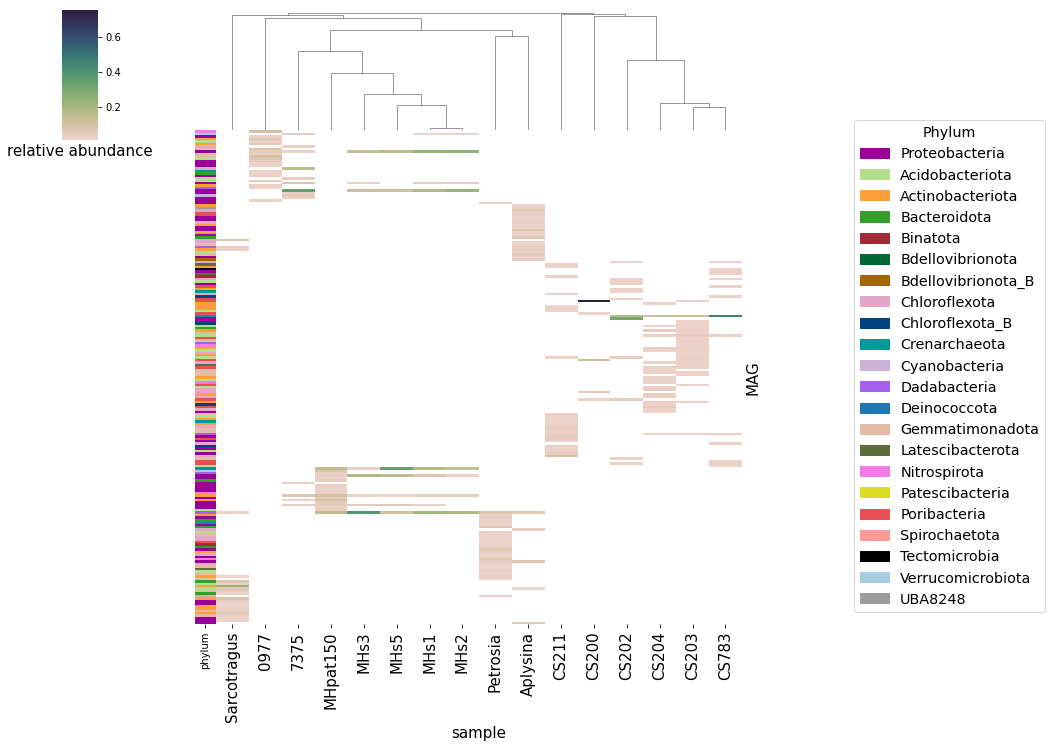

In [21]:
'''
Clustering based on all MAGs above 1% threshold should be used for inference of how similar
metagenomes are (if at all)!

Metrics other than 'cosine':
'sqeuclidean','seuclidean','average'
'''
row_colors = gtdb_df["phylum"].map(color_map)

wx = seaborn.clustermap(cluster_pivo_Aall_excl_low[(cluster_pivo_Aall_excl_low.T != 0).any()], 
                        cmap=seaborn.cubehelix_palette(start=0.6, rot=-1, as_cmap=True),
                        row_cluster=False, 
                        yticklabels=False, 
                        row_colors=row_colors,
                        mask = cluster_pivo_Aall_excl_low[(cluster_pivo_Aall_excl_low.T != 0).any()]==0, 
                        metric='cosine')
ax = wx.ax_heatmap
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 15)
ax.set_ylabel("MAG", fontsize=15)
ax.set_xlabel("sample", fontsize=15)

patchs = [mpatches.Patch(color=v, label=k) for k, v in color_map.items()]

legend = plt.legend(handles=patchs,bbox_to_anchor=(27.5, 0.21), title="Phylum", fontsize='x-large')
plt.setp(legend.get_title(),fontsize='x-large')
plt.xlabel('relative abundance', fontsize=15)


In [22]:
#wx.savefig("/Users/vincentn/Documents/Sequencing/Sponge_paper_sample_vs_abundance_250820/Final_one_perc_MAGs_with_gtdb_tk_taxonomy_cos.pdf")


In [23]:
# Create dataframe for presence or absence clustering
cluster_pivo_Aall_excl_low_binary = cluster_pivo_Aall_excl_low.copy()
cluster_pivo_Aall_excl_low_binary[cluster_pivo_Aall_excl_low_binary>0.0] = 1
cluster_pivo_Aall_excl_low_binary.head(5)

sample,0977,7375,CS200,CS202,CS203,CS204,CS211,CS783,MHpat150,MHs1,MHs2,MHs3,MHs5,Petrosia,Sarcotragus,Aplysina
bin_sample,,,,,,,,,,,,,,,,
0977_bin.1.fa.maxbin2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0977_bin.10.fa.metabat2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
0977_bin.100.fa.metabat2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0977_bin.101.fa.metabat2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0977_bin.103.fa.metabat2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


[None, None]

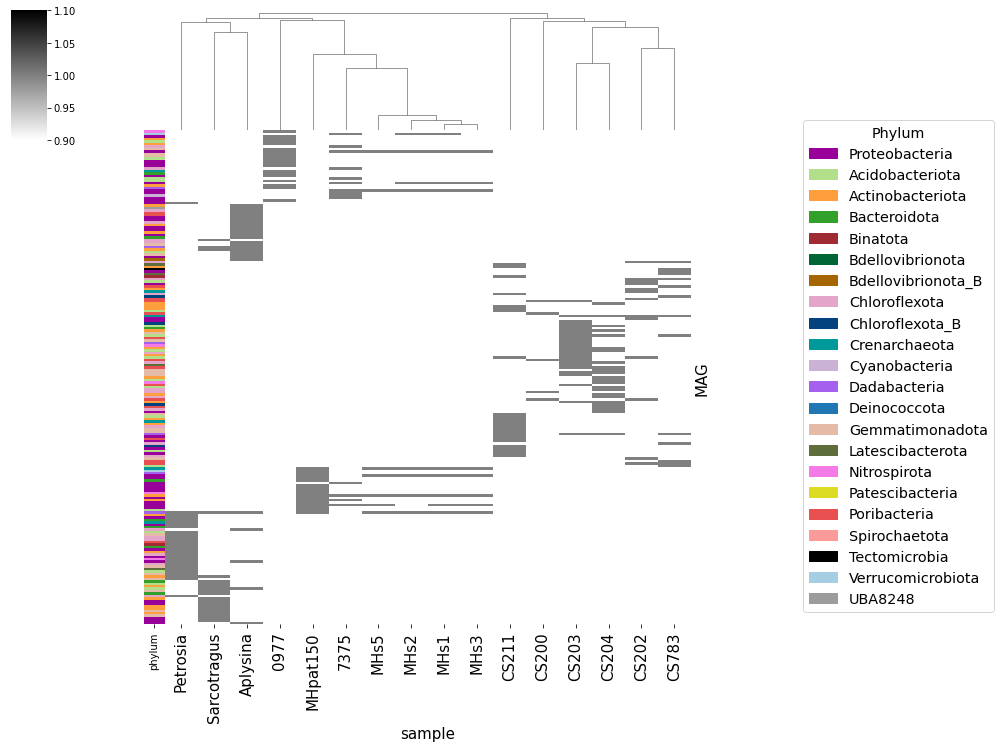

In [24]:
row_colors = gtdb_df["phylum"].map(color_map)

vx = seaborn.clustermap(cluster_pivo_Aall_excl_low_binary[(cluster_pivo_Aall_excl_low_binary.T != 0).any()], 
                        cmap='binary',
                        row_cluster=False, 
                        yticklabels=False, 
                        row_colors=row_colors,
                        mask = cluster_pivo_Aall_excl_low_binary[(cluster_pivo_Aall_excl_low_binary.T != 0).any()]==0, 
                        metric='cosine')

ax = vx.ax_heatmap
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 15)
ax.set_ylabel("MAG", fontsize=15)
ax.set_xlabel("sample", fontsize=15)

patchs = [mpatches.Patch(color=v, label=k) for k, v in color_map.items()]

legend = plt.legend(handles=patchs,bbox_to_anchor=(27.5, 0.21), title="Phylum", fontsize='x-large')
plt.setp(legend.get_title(),fontsize='x-large')
#plt.xlabel('relative abundance', fontsize=12)


In [25]:
#vx.savefig("/Users/vincentn/Documents/Sequencing/Sponge_paper_sample_vs_abundance_250820/Final_binary_one_perc_MAGs_with_gtdb_tk_taxonomy_cos.pdf")


Text(0.5, 530.7636363636364, 'relative abundance')

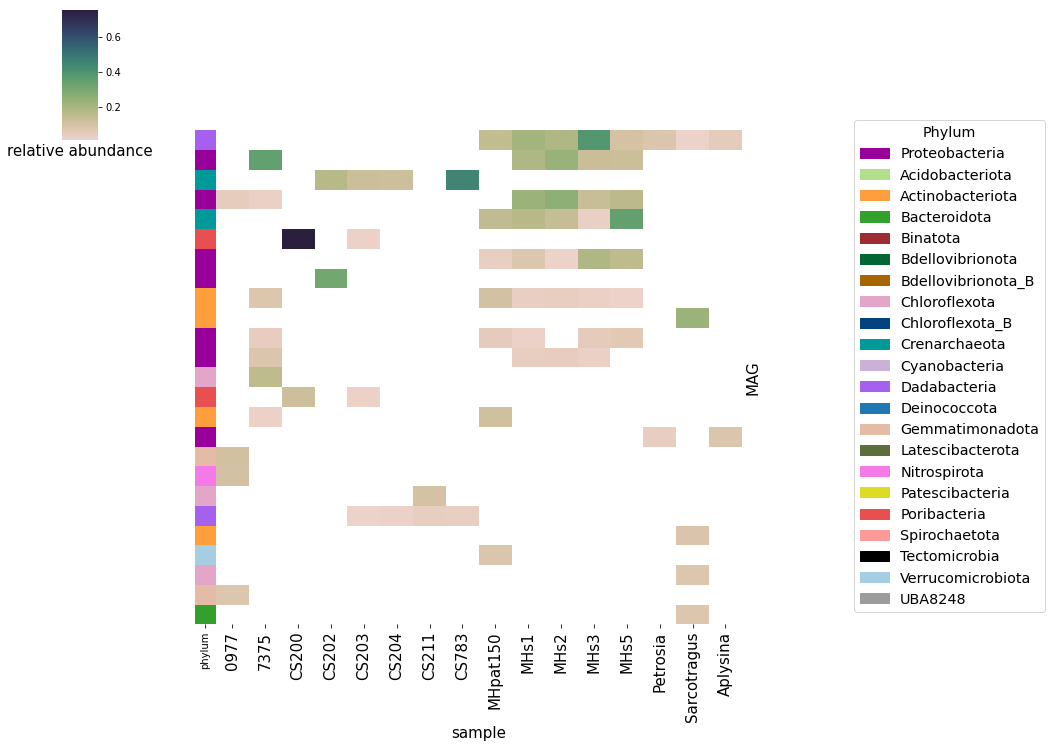

In [26]:
row_colors = gtdb_df["phylum"].map(color_map)

xx = seaborn.clustermap(abund_25.drop(columns=["average_abund"]), 
                        cmap=seaborn.cubehelix_palette(start=0.6, rot=-1, as_cmap=True),
                        row_cluster=False,
                        col_cluster=False,
                        yticklabels=False,
                        mask = abund_25.drop(columns=["average_abund"])==0, 
                        row_colors=row_colors, metric='cosine')

ax = xx.ax_heatmap
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 15)
ax.set_ylabel("MAG", fontsize=15)
ax.set_xlabel("sample", fontsize=15)

patchs = [mpatches.Patch(color=v, label=k) for k, v in color_map.items()]

legend = plt.legend(handles=patchs,bbox_to_anchor=(27.5, 0.21), title="Phylum", fontsize='x-large')
plt.setp(legend.get_title(),fontsize='x-large')
plt.xlabel('relative abundance', fontsize=15)


In [27]:
#xx.savefig("/Users/vincentn/Documents/Sequencing/Sponge_paper_sample_vs_abundance_250820/Final_25_most_abundant_MAGs_with_gtdb_tk_taxonomy_cos.pdf")


## Abundance profile

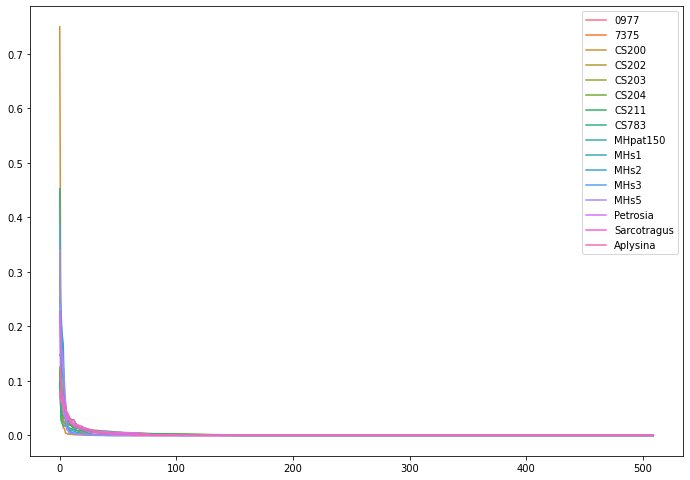

In [28]:
abundance_profile = cluster_pivo_Aall.copy()
abundance_profile_sorted = pd.concat([abundance_profile[col].sort_values(ascending=False).reset_index(drop=True) for col in abundance_profile], axis=1)
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
plt.legend(abundance_profile.columns)
ix = seaborn.lineplot(data=abundance_profile_sorted, ax=ax, dashes=False, sort=True)

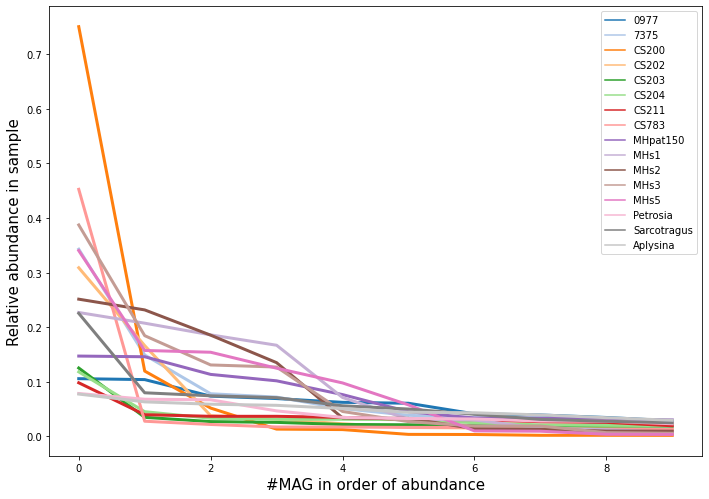

In [29]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
plt.legend(abundance_profile.columns, fontsize='x-large')
plt.xlabel('#MAG in order of abundance', fontsize=15)
plt.ylabel('Relative abundance in sample', fontsize=15)
jx = seaborn.lineplot(data=abundance_profile_sorted.head(10), ax=ax, dashes=False, 
                      sort=True, palette="tab20", linewidth=3.0)
#plt.savefig("/Users/vincentn/Documents/Sequencing/Sponge_paper_sample_vs_abundance_250820/Final_abundance_profile_10.png")

In [30]:
# Long format df with sample, MAG, taxonomy and abundance
abundance_profile_long = pd.melt(abundance_profile.reset_index(), id_vars='bin_sample')
print(len(abundance_profile_long))
abundance_profile_long_tax = pd.merge(abundance_profile_long,gtdb_df, on='bin_sample')
print(len(abundance_profile_long_tax))
abundance_profile_long_tax = abundance_profile_long_tax[["bin_sample","sample","value","phylum"]]
abundance_profile_long_tax = abundance_profile_long_tax.sort_values(['sample','value'], ascending=False)
# Subset for 10 highest values in each sample
abundance_profile_long_tax_top10 = abundance_profile_long_tax.groupby('sample').nth([0,1,2,3,4,5,6,7,8,9])
abundance_profile_long_tax_top10 = abundance_profile_long_tax_top10.sort_values(["sample","value"], ascending=False)
abundance_profile_long_tax_top10.reset_index(inplace=True)
# Input integers for order to be used in FacetGrid
pat = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
abundance_profile_long_tax_top10 = abundance_profile_long_tax_top10.assign(new_column=[*islice(cycle(pat), len(abundance_profile_long_tax_top10))])
abundance_profile_long_tax_top10 = abundance_profile_long_tax_top10.rename(columns={'value':'relative_abundance', "new_column":"abundance_order"})
abundance_profile_long_tax_top10


8160
8160


,sample,bin_sample,relative_abundance,phylum,abundance_order
0,Sarcotragus,Sarcotragus_bin.37.fa.metabat2,0.225398,Actinobacteriota,1
1,Sarcotragus,Sarcotragus_bin.52.fa.metabat2,0.079998,Actinobacteriota,2
2,Sarcotragus,Aplysina_bin.56.fa.metabat2,0.074491,Chloroflexota,3
3,Sarcotragus,Sarcotragus_bin.2.fa.maxbin2,0.071110,Bacteroidota,4
4,Sarcotragus,Sarcotragus_bin.4.fa.maxbin2,0.056206,Acidobacteriota,5
...,...,...,...,...,...
155,0977,0977_bin.109.fa.metabat2,0.060841,Actinobacteriota,6
156,0977,0977_bin.74.fa.metabat2,0.041445,Acidobacteriota,7
157,0977,0977_bin.12.fa.maxbin2,0.039408,Proteobacteria,8
158,0977,0977_bin.15.fa.maxbin2,0.034788,Proteobacteria,9


In [37]:
ten_most_abundant_MAGs_per_sample = abundance_profile_long_tax_top10['bin_sample'].tolist()
with open('/Users/vincentn/Documents/Sequencing/Sponge_paper_sample_vs_abundance_250820/ten_most_abundant_MAGs_per_sample.txt', 'w') as f:
    for listitem in ten_most_abundant_MAGs_per_sample:
        f.write(f'{listitem}\n')

ten_most_abundant_MAGs_per_sample


['Sarcotragus_bin.37.fa.metabat2',
 'Sarcotragus_bin.52.fa.metabat2',
 'Aplysina_bin.56.fa.metabat2',
 'Sarcotragus_bin.2.fa.maxbin2',
 'Sarcotragus_bin.4.fa.maxbin2',
 'Sarcotragus_cluster_DBSCAN_round1_2',
 'Sarcotragus_bin.40.fa.metabat2',
 'Sarcotragus_bin.7.fa.maxbin2',
 'Sarcotragus_bin.55.fa.metabat2',
 'Sarcotragus_cluster_DBSCAN_round2082_37',
 'Petrosia_bin.0.fa.maxbin2',
 'Petrosia_bin.28.fa.metabat2',
 'Petrosia_bin.75.fa.metabat2',
 'Petrosia_bin.6.fa.metabat2',
 'Petrosia_bin.4.fa.maxbin2',
 'Petrosia_bin.62.fa.metabat2',
 'Petrosia_bin.76.fa.metabat2',
 'Petrosia_bin.11.fa.metabat2',
 'Petrosia_cluster_DBSCAN_round3784_3',
 'Petrosia_bin.43.fa.metabat2',
 'MHpat150_bin.0.fa.maxbin2',
 '0977_bin.12.fa.maxbin2',
 'MHpat150_bin.15.fa.maxbin2',
 '7375_bin.0.fa.maxbin2',
 'Petrosia_bin.0.fa.maxbin2',
 'MHs3_bin.4.fa.maxbin2',
 'MHs1_bin.2.fa.maxbin2',
 '0977_bin.89.fa.metabat2',
 '0977_bin.10.fa.metabat2',
 'MHs5_bin.2.fa.metabat2',
 'Petrosia_bin.0.fa.maxbin2',
 'MHpat150_bi

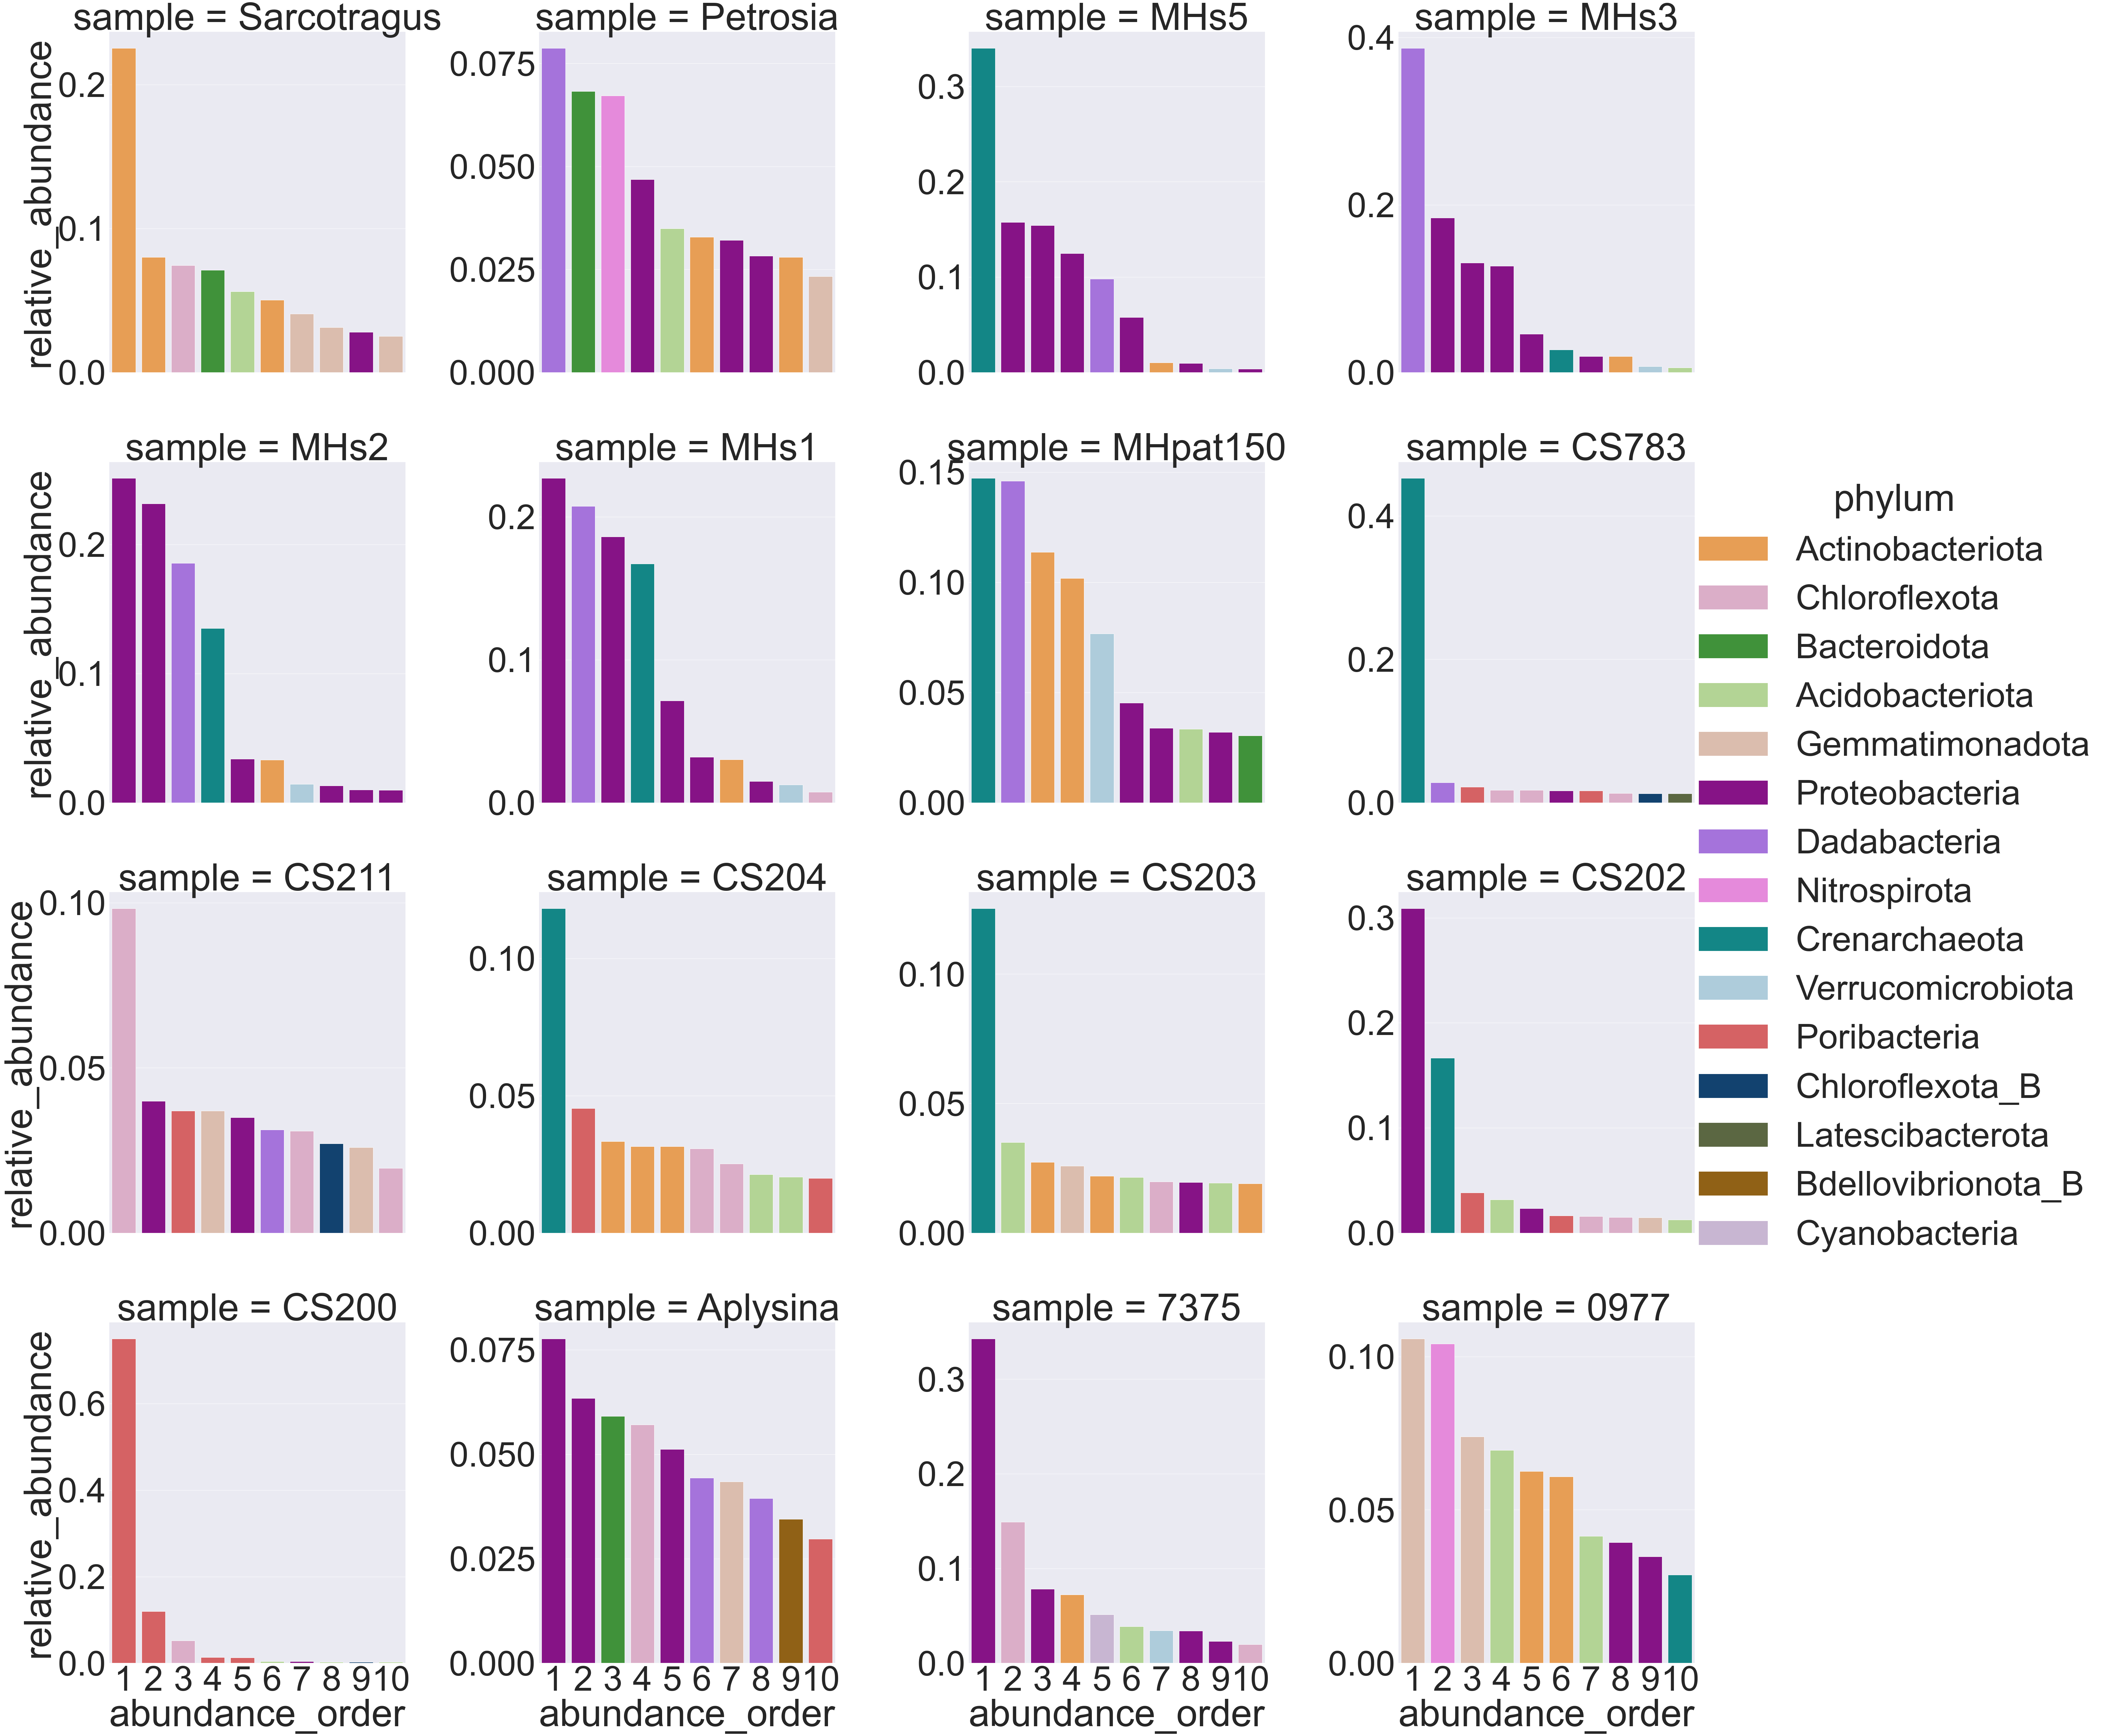

In [31]:
# Need to put shared x-axis value through order (1-10) doesn't remediate the problem
order_input = abundance_profile_long_tax_top10.abundance_order.unique()
seaborn.set(font_scale=10)
abund10_sample_plot = seaborn.FacetGrid(abundance_profile_long_tax_top10, col="sample", 
                      hue='phylum', height=20, col_wrap=4, sharey=False, palette=color_map)
abund10_sample_plot.map(seaborn.barplot, "abundance_order", "relative_abundance", order=order_input)
#g.map(seaborn.barplot, "bin_sample", "value")
abund10_sample_plot.add_legend()
#plt.legend( title="Phylum", fontsize="large", bbox_to_anchor=(-0.1, 0.5))

In [32]:
#abund10_sample_plot.savefig("/Users/vincentn/Documents/Sequencing/Sponge_paper_sample_vs_abundance_250820/abund10_sample_plot.pdf")


In [33]:
abundance_profile_long_tax_top10["phylum"].value_counts()

Proteobacteria        45
Actinobacteriota      20
Chloroflexota         17
Acidobacteriota       17
Poribacteria          12
Gemmatimonadota       11
Dadabacteria          10
Crenarchaeota         10
Verrucomicrobiota      6
Bacteroidota           4
Chloroflexota_B        3
Nitrospirota           2
Latescibacterota       1
Bdellovibrionota_B     1
Cyanobacteria          1
Name: phylum, dtype: int64

In [34]:
# Quick sanity check on most abundant MAG from CS783
# This "species-level" MAG actually occurs in most Tongan sponges
norm_cov_75_df[norm_cov_75_df["bin_sample"] == 'CS202_bin.90.fa.maxbin2']

,bin_sample,sample,Avg_fold
939,CS202_bin.90.fa.maxbin2,CS200,0.000200
940,CS202_bin.90.fa.maxbin2,CS202,0.166383
941,CS202_bin.90.fa.maxbin2,CS203,0.125346
942,CS202_bin.90.fa.maxbin2,CS204,0.118275
943,CS202_bin.90.fa.maxbin2,CS783,0.452464


In [35]:
gtdb_df.loc["CS202_bin.90.fa.maxbin2",'classification']

'd__Archaea;p__Crenarchaeota;c__Nitrososphaeria;o__Nitrososphaerales;f__Nitrosopumilaceae;g__Cenarchaeum;s__'

In [36]:
# Investigate Crenarchaeota MAG abundant in MHs5
#abundance_profile_long_tax_top10[abundance_profile_long_tax_top10["sample"] == 'MHs5']
norm_cov_75_df[norm_cov_75_df["bin_sample"] == 'MHpat150_bin.0.fa.maxbin2']

,bin_sample,sample,Avg_fold
1445,MHpat150_bin.0.fa.maxbin2,0977,0.000287
1446,MHpat150_bin.0.fa.maxbin2,7375,0.000509
1447,MHpat150_bin.0.fa.maxbin2,MHpat150,0.147219
1448,MHpat150_bin.0.fa.maxbin2,MHs1,0.167029
1449,MHpat150_bin.0.fa.maxbin2,MHs2,0.135165
1450,MHpat150_bin.0.fa.maxbin2,MHs3,0.027232
1451,MHpat150_bin.0.fa.maxbin2,MHs5,0.340289


In [37]:
# Investigate Poribacteria MAG abundant in CS200
#abundance_profile_long_tax_top10[abundance_profile_long_tax_top10["sample"] == 'CS200']
norm_cov_75_df[norm_cov_75_df["bin_sample"] == 'CS200_cluster_DBSCAN_round3775_2397']

,bin_sample,sample,Avg_fold
807,CS200_cluster_DBSCAN_round3775_2397,CS200,0.750183
808,CS200_cluster_DBSCAN_round3775_2397,CS202,0.003926
809,CS200_cluster_DBSCAN_round3775_2397,CS203,0.016467
810,CS200_cluster_DBSCAN_round3775_2397,CS204,0.003441
811,CS200_cluster_DBSCAN_round3775_2397,CS211,0.003032


In [38]:
gtdb_df.loc['CS200_cluster_DBSCAN_round3775_2397','classification']

'd__Bacteria;p__Poribacteria;c__WGA-4E;o__WGA-4E;f__WGA-3G;g__WGA-3G;s__'

# Taxonomic group summaries based on all 643 MAGs

In [39]:
gtdb_df_mod = gtdb_df.copy()
#gtdb_df_mod['phylum'] = gtdb_df_mod['phylum'].replace(['Gammaproteobacteria','Alphaproteobacteria'],'Proteobacteria')


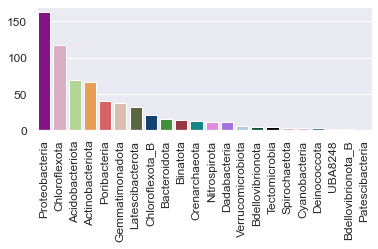

In [40]:
seaborn.set()
MAG_summary_643 = seaborn.barplot(y=gtdb_df_mod["phylum"].value_counts().values, 
                                  x=gtdb_df_mod["phylum"].value_counts().index,
                                 palette=color_map)
plt.xticks(rotation=90, fontsize=12)
plt.yticks(fontsize=12)
plt.subplots_adjust(bottom=0.45)
#plt.savefig("/Users/vincentn/Documents/Sequencing/Sponge_paper_sample_vs_abundance_250820/MAG_summary_643.pdf")


In [41]:
gtdb_df_mod["phylum"].value_counts()

Proteobacteria        162
Chloroflexota         117
Acidobacteriota        69
Actinobacteriota       67
Poribacteria           40
Gemmatimonadota        37
Latescibacterota       32
Chloroflexota_B        21
Bacteroidota           16
Binatota               15
Crenarchaeota          13
Nitrospirota           12
Dadabacteria           11
Verrucomicrobiota       6
Bdellovibrionota        5
Tectomicrobia           5
Spirochaetota           4
Cyanobacteria           3
Deinococcota            3
UBA8248                 2
Bdellovibrionota_B      2
Patescibacteria         1
Name: phylum, dtype: int64

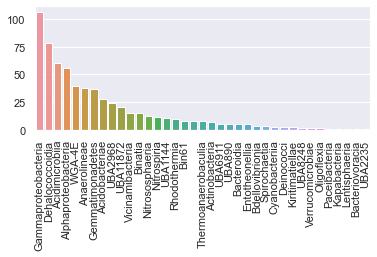

In [42]:
MAG__class_summary_643 = seaborn.barplot(y=gtdb_df_mod["class"].value_counts().values, x=gtdb_df_mod["class"].value_counts().index)
plt.xticks(rotation=90)
plt.subplots_adjust(bottom=0.45)

In [43]:
gtdb_df_mod.drop(columns='index')
gtdb_df_mod.reset_index(inplace=True)
gtdb_df_mod["sample"] = gtdb_df_mod["bin_sample"].str.split("_", expand=True)[0]
MAG_by_sample_643_df = gtdb_df_mod.groupby("sample")["phylum"].value_counts().to_frame()
MAG_by_sample_643_df = MAG_by_sample_643_df.rename(columns={"phylum":"count"})
MAG_by_sample_643_df = MAG_by_sample_643_df.reset_index()
MAG_by_sample_643_pivo = MAG_by_sample_643_df.pivot(index='sample', columns="phylum", values='count')
MAG_by_sample_643_pivo = MAG_by_sample_643_pivo.reset_index()
# Make sample a categorical column and sort by it to have wanted order in figure
MAG_by_sample_643_pivo['sample'] = pd.Categorical(MAG_by_sample_643_pivo['sample'], 
            ["0977","7375","MHpat150","MHs1","MHs2","MHs3","MHs5","CS200","CS202",
            "CS203","CS204","CS211","CS783","Aplysina","Petrosia","Sarcotragus"])
MAG_by_sample_643_pivo = MAG_by_sample_643_pivo.sort_values('sample', ascending=False)
MAG_by_sample_643_pivo


phylum,sample,Acidobacteriota,Actinobacteriota,Bacteroidota,Bdellovibrionota,Bdellovibrionota_B,Binatota,Chloroflexota,Chloroflexota_B,Crenarchaeota,...,Gemmatimonadota,Latescibacterota,Nitrospirota,Patescibacteria,Poribacteria,Proteobacteria,Spirochaetota,Tectomicrobia,UBA8248,Verrucomicrobiota
15,Sarcotragus,5.0,6.0,2.0,NaN,NaN,NaN,7.0,1.0,NaN,...,4.0,1.0,NaN,NaN,1.0,15.0,NaN,NaN,NaN,NaN
14,Petrosia,5.0,5.0,4.0,NaN,NaN,3.0,10.0,1.0,2.0,...,6.0,1.0,1.0,NaN,1.0,7.0,1.0,1.0,1.0,NaN
2,Aplysina,9.0,9.0,3.0,1.0,2.0,3.0,14.0,1.0,1.0,...,3.0,2.0,1.0,1.0,2.0,21.0,2.0,1.0,1.0,NaN
8,CS783,5.0,3.0,NaN,1.0,NaN,1.0,8.0,3.0,1.0,...,2.0,4.0,1.0,NaN,5.0,7.0,1.0,NaN,NaN,NaN
7,CS211,7.0,2.0,NaN,NaN,NaN,1.0,17.0,2.0,2.0,...,4.0,2.0,1.0,NaN,6.0,9.0,NaN,1.0,NaN,NaN
6,CS204,5.0,5.0,1.0,1.0,NaN,NaN,12.0,2.0,2.0,...,3.0,3.0,1.0,NaN,6.0,7.0,NaN,1.0,NaN,NaN
5,CS203,5.0,7.0,2.0,NaN,NaN,NaN,11.0,2.0,1.0,...,5.0,6.0,1.0,NaN,5.0,6.0,NaN,NaN,NaN,NaN
4,CS202,5.0,6.0,1.0,NaN,NaN,2.0,9.0,3.0,1.0,...,2.0,5.0,1.0,NaN,5.0,14.0,NaN,NaN,NaN,NaN
3,CS200,7.0,6.0,1.0,1.0,NaN,3.0,23.0,5.0,1.0,...,2.0,6.0,1.0,NaN,8.0,12.0,NaN,1.0,NaN,1.0
13,MHs5,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN


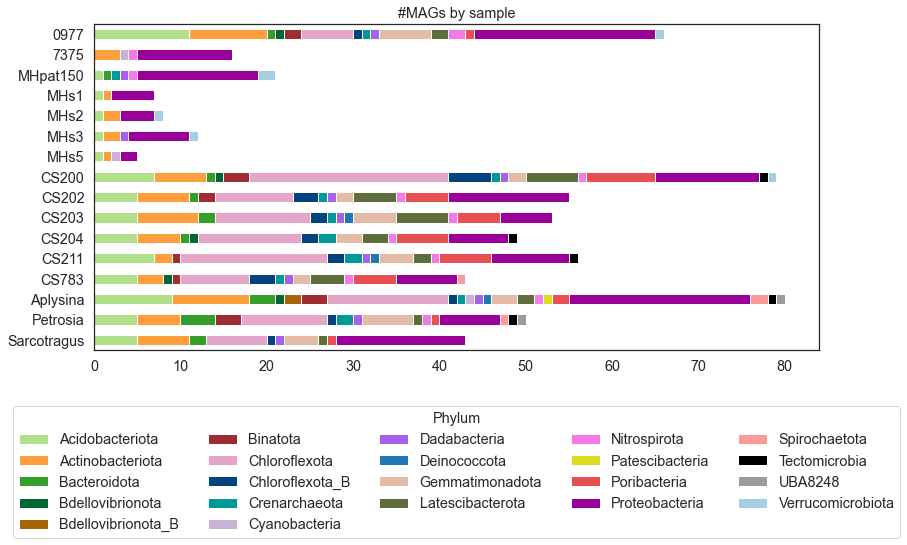

In [45]:
# color_map = {'Proteobacteria':"#990099",
#  'Acidobacteriota':"#b2df8a",
#  'Actinobacteriota':"#ff9e3d",
#  'Bacteroidota':"#33a02c",
#  'Binatota':"#a02c33",
#  'Bdellovibrionota':"#006633",
#  'Bdellovibrionota_B':"#a46502",
#  'Chloroflexota':"#e3a6c9",
#  'Chloroflexota_B':'#02437f',
#  'Crenarchaeota':'#009999',
#  'Cyanobacteria':"#cab2d6",
#  'Dadabacteria':"#a561ed",
#  'Deinococcota':"#1f78b4",
#  'Gemmatimonadota':'#e3bba6',
#  'Latescibacterota':'#5d6d3c',
#  'Nitrospirota':"#F47BE7",
#  'Patescibacteria':"#dcdc23", 
#  'Poribacteria':"#e84f51",
#  'Spirochaetota':"#fb9a99",
#  'Tectomicrobia':"#000000",
#  'Verrucomicrobiota':'#a6cee3',
#  'UBA8248':"#9c9c9c"}

# Need to change into alphabetcially ordered list (by phylum name)

seaborn.set_style("white")
colors = ["#b2df8a","#ff9e3d","#33a02c","#006633","#a46502","#a02c33","#e3a6c9",'#02437f',
          '#009999',"#cab2d6","#a561ed","#1f78b4",'#e3bba6','#5d6d3c',"#F47BE7","#dcdc23",
          "#e84f51","#990099","#fb9a99","#000000",'#9c9c9c',"#a6cee3"]
cmap = ListedColormap(colors)

#row_colors = MAG_by_sample_643_df["phylum"].map(color_map2)

MAG_by_sample_643_plot = MAG_by_sample_643_pivo.plot(x='sample', ylabel=None,
                                                     fontsize="large",
                                                     kind='barh', stacked=True, 
                                         colormap=cmap, figsize=(13,6))

plt.title('#MAGs by sample', fontsize='large')
plt.legend( title="Phylum", title_fontsize='large', loc='upper center', fontsize="large",
           bbox_to_anchor=(0.5, -0.15), ncol=5)
plt.ylabel(None)
plt.savefig("/Users/vincentn/Documents/Sequencing/Sponge_paper_sample_vs_abundance_250820/MAG_by_sample_643_plot.pdf",
           bbox_inches='tight')


In [78]:
gtdb_df_mod[gtdb_df_mod["class"] == '']

,bin_sample,index,classification,phylum,class,order,sample
27,0977_bin.108.fa.metabat2,27,d__Bacteria;p__Latescibacterota;c__;o__;f__;g_...,Latescibacterota,,,0977
100,CS202_bin.40.fa.metabat2,100,d__Bacteria;p__Latescibacterota;c__;o__;f__;g_...,Latescibacterota,,,CS202
173,Sarcotragus_bin.44.fa.metabat2,173,d__Bacteria;p__Latescibacterota;c__;o__;f__;g_...,Latescibacterota,,,Sarcotragus
250,CS200_bin.12.fa.maxbin2,250,d__Bacteria;p__Latescibacterota;c__;o__;f__;g_...,Latescibacterota,,,CS200
306,CS783_bin.9.fa.metabat2,306,d__Bacteria;p__Latescibacterota;c__;o__;f__;g_...,Latescibacterota,,,CS783
387,Aplysina_bin.131.fa.metabat2,387,d__Bacteria;p__Latescibacterota;c__;o__;f__;g_...,Latescibacterota,,,Aplysina
551,CS204_bin.58.fa.maxbin2,551,d__Bacteria;p__Latescibacterota;c__;o__;f__;g_...,Latescibacterota,,,CS204
608,CS203_cluster_DBSCAN_round5_9,608,d__Bacteria;p__Latescibacterota;c__;o__;f__;g_...,Latescibacterota,,,CS203


In [79]:
print(len(gtdb_df_mod[gtdb_df_mod["order"] == '']))
gtdb_df_mod[gtdb_df_mod["order"] == '']["phylum"].value_counts()

52


Acidobacteriota      14
Dadabacteria         11
Latescibacterota      8
Gemmatimonadota       7
Chloroflexota_B       6
Verrucomicrobiota     4
Chloroflexota         2
Name: phylum, dtype: int64

In [80]:
print(len(gtdb_df_mod))
print(len(gtdb_df_mod[gtdb_df_mod["phylum"] == 'Acidobacteriota']))

643
69


In [81]:
gtdb_df_mod[(gtdb_df_mod["order"] == '') & (gtdb_df_mod["phylum"] == 'Acidobacteriota')]

,bin_sample,index,classification,phylum,class,order,sample
60,0977_cluster_DBSCAN_round43_9,60,d__Bacteria;p__Acidobacteriota;c__Acidobacteri...,Acidobacteriota,Acidobacteriae,,0977
61,0977_bin.29.fa.metabat2,61,d__Bacteria;p__Acidobacteriota;c__UBA6911;o__;...,Acidobacteriota,UBA6911,,0977
126,CS202_bin.77.fa.metabat2,126,d__Bacteria;p__Acidobacteriota;c__Acidobacteri...,Acidobacteriota,Acidobacteriae,,CS202
127,CS202_bin.48.fa.metabat2,127,d__Bacteria;p__Acidobacteriota;c__UBA6911;o__;...,Acidobacteriota,UBA6911,,CS202
191,Sarcotragus_cluster_DBSCAN_round40_1,191,d__Bacteria;p__Acidobacteriota;c__Acidobacteri...,Acidobacteriota,Acidobacteriae,,Sarcotragus
280,CS200_cluster_DBSCAN_round3821_60,280,d__Bacteria;p__Acidobacteriota;c__Acidobacteri...,Acidobacteriota,Acidobacteriae,,CS200
281,CS200_cluster_DBSCAN_round3821_59,281,d__Bacteria;p__Acidobacteriota;c__UBA6911;o__;...,Acidobacteriota,UBA6911,,CS200
324,CS783_cluster_DBSCAN_round3529_3,324,d__Bacteria;p__Acidobacteriota;c__Acidobacteri...,Acidobacteriota,Acidobacteriae,,CS783
325,CS783_bin.6.fa.metabat2,325,d__Bacteria;p__Acidobacteriota;c__UBA6911;o__;...,Acidobacteriota,UBA6911,,CS783
472,CS211_bin.18.fa.maxbin2,472,d__Bacteria;p__Acidobacteriota;c__Acidobacteri...,Acidobacteriota,Acidobacteriae,,CS211


# Taxonomic group summaries based on 510 species-level MAGs

In [82]:
tax_summary_df = pd.merge(cluster_pivo_Aall, gtdb_df, how='left', on='bin_sample')

In [83]:
tax_summary_df

,0977,7375,CS200,CS202,CS203,CS204,CS211,CS783,MHpat150,MHs1,...,MHs3,MHs5,Petrosia,Sarcotragus,Aplysina,index,classification,phylum,class,order
bin_sample,,,,,,,,,,,,,,,,,,,,,
0977_bin.1.fa.maxbin2,0.104139,0.001353,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,52,d__Bacteria;p__Nitrospirota;c__Nitrospiria;o__...,Nitrospirota,Nitrospiria,Nitrospirales
0977_bin.10.fa.metabat2,0.000868,0.034408,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.012444,...,0.00702,0.004038,0.000000,0.000000,0.000000,18,d__Bacteria;p__Verrucomicrobiota;c__Verrucomic...,Verrucomicrobiota,Verrucomicrobiae,Verrucomicrobiales
0977_bin.100.fa.metabat2,0.011027,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,32,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,Proteobacteria,Gammaproteobacteria,Pseudomonadales
0977_bin.101.fa.metabat2,0.062529,0.000541,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,10,d__Bacteria;p__Actinobacteriota;c__Acidimicrob...,Actinobacteriota,Acidimicrobiia,UBA5794
0977_bin.103.fa.metabat2,0.003346,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,43,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,Proteobacteria,Gammaproteobacteria,UBA10353
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sarcotragus_cluster_DBSCAN_round4_19,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.00000,0.000000,0.000000,0.002756,0.000000,181,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,Proteobacteria,Gammaproteobacteria,UBA10353
Sarcotragus_cluster_DBSCAN_round4_6,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.00000,0.000000,0.000000,0.014739,0.007291,188,d__Bacteria;p__Proteobacteria;c__Alphaproteoba...,Proteobacteria,Alphaproteobacteria,Rhodospirillales_A
Sarcotragus_cluster_DBSCAN_round5_4,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.00000,0.000000,0.002035,0.005808,0.000000,168,d__Bacteria;p__Chloroflexota_B;c__UBA11872;o__...,Chloroflexota_B,UBA11872,UBA11872


In [84]:
tax_summary_df["phylum"].value_counts()

Proteobacteria        134
Chloroflexota          98
Actinobacteriota       54
Acidobacteriota        45
Gemmatimonadota        30
Poribacteria           29
Latescibacterota       24
Chloroflexota_B        18
Bacteroidota           14
Binatota               13
Crenarchaeota          11
Nitrospirota           10
Dadabacteria            8
Verrucomicrobiota       4
Bdellovibrionota        4
Spirochaetota           4
Tectomicrobia           3
Cyanobacteria           2
Bdellovibrionota_B      2
UBA8248                 1
Deinococcota            1
Patescibacteria         1
Name: phylum, dtype: int64

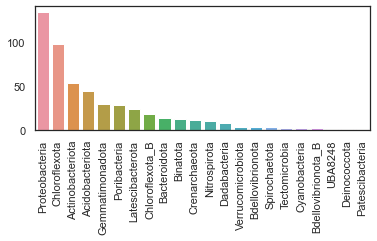

In [85]:
MAG_summary = seaborn.barplot(y=tax_summary_df["phylum"].value_counts().values, x=tax_summary_df["phylum"].value_counts().index)
plt.xticks(rotation=90)
plt.subplots_adjust(bottom=0.45)
#plt.savefig("/home/vincent/Documents/Sponge_paper_sample_vs_abundance_250820/MAG_summary.pdf")

In [86]:
tax_summary_df["class"].value_counts()

Gammaproteobacteria    93
Dehalococcoidia        72
Acidimicrobiia         52
Alphaproteobacteria    41
Gemmatimonadetes       30
WGA-4E                 29
Anaerolineae           25
Acidobacteriae         18
UBA11872               18
UBA2968                16
Binatia                13
Vicinamibacteria       11
Nitrososphaeria        11
Nitrospiria            10
Rhodothermia            8
                        8
UBA1144                 8
Thermoanaerobaculia     7
Bin61                   5
Bacteroidia             5
Spirochaetia            4
Bdellovibrionia         3
UBA6911                 3
Entotheonellia          3
Actinobacteria          2
Cyanobacteriia          2
Verrucomicrobiae        2
Oligoflexia             2
Kiritimatiellae         1
Lentisphaeria           1
UBA890                  1
Deinococci              1
UBA2235                 1
Paceibacteria           1
UBA8248                 1
Bacteriovoracia         1
Kapabacteria            1
Name: class, dtype: int64

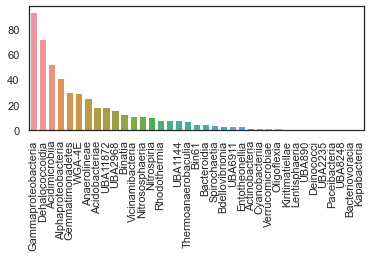

In [87]:
MAG__class_summary = seaborn.barplot(y=tax_summary_df["class"].value_counts().values, x=tax_summary_df["class"].value_counts().index)
plt.xticks(rotation=90)
plt.subplots_adjust(bottom=0.45)

In [88]:
print(len(tax_summary_df[tax_summary_df["phylum"] == 'Latescibacterota']))
tax_summary_df[tax_summary_df["class"] == '']

24


,0977,7375,CS200,CS202,CS203,CS204,CS211,CS783,MHpat150,MHs1,...,MHs3,MHs5,Petrosia,Sarcotragus,Aplysina,index,classification,phylum,class,order
bin_sample,,,,,,,,,,,,,,,,,,,,,
0977_bin.108.fa.metabat2,0.001791,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,27,d__Bacteria;p__Latescibacterota;c__;o__;f__;g_...,Latescibacterota,,
Aplysina_bin.131.fa.metabat2,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.004316,0.000000,0.002143,387,d__Bacteria;p__Latescibacterota;c__;o__;f__;g_...,Latescibacterota,,
CS200_bin.12.fa.maxbin2,0.000000,0.0,0.000000,0.008866,0.002041,0.001253,0.015191,0.007916,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,250,d__Bacteria;p__Latescibacterota;c__;o__;f__;g_...,Latescibacterota,,
CS202_bin.40.fa.metabat2,0.000000,0.0,0.001605,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,100,d__Bacteria;p__Latescibacterota;c__;o__;f__;g_...,Latescibacterota,,
CS203_cluster_DBSCAN_round5_9,0.000000,0.0,0.000000,0.000000,0.014824,0.002280,0.000837,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,608,d__Bacteria;p__Latescibacterota;c__;o__;f__;g_...,Latescibacterota,,
CS204_bin.58.fa.maxbin2,0.000000,0.0,0.000070,0.000625,0.003245,0.006196,0.007525,0.003978,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,551,d__Bacteria;p__Latescibacterota;c__;o__;f__;g_...,Latescibacterota,,
CS783_bin.9.fa.metabat2,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.008200,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,306,d__Bacteria;p__Latescibacterota;c__;o__;f__;g_...,Latescibacterota,,
Sarcotragus_bin.44.fa.metabat2,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.004526,0.003032,0.002462,173,d__Bacteria;p__Latescibacterota;c__;o__;f__;g_...,Latescibacterota,,


# Entotheonella

In [128]:
tax_summary_df[tax_summary_df["phylum"]=="Tectomicrobia"]

,0977,7375,CS200,CS202,CS203,CS204,CS211,CS783,MHpat150,MHs1,MHs2,MHs3,MHs5,Petrosia,Sarcotragus,Aplysina,index,classification,phylum,class
bin_sample,,,,,,,,,,,,,,,,,,,,
Aplysina_cluster_DBSCAN_round72_0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.005147,0.001632,0.000999,401,d__Bacteria;p__Tectomicrobia;c__Entotheonellia...,Tectomicrobia,Entotheonellia
CS200_bin.19.fa.maxbin2,0.0,0.0,0.000150,0.008493,0.004937,0.005847,0.004737,0.011409,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,273,d__Bacteria;p__Tectomicrobia;c__Entotheonellia...,Tectomicrobia,Entotheonellia
CS204_bin.102.fa.metabat2,0.0,0.0,0.000065,0.000000,0.001859,0.005602,0.001263,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,566,d__Bacteria;p__Tectomicrobia;c__Entotheonellia...,Tectomicrobia,Entotheonellia


## Note that while no bins from CS783 were identified as CS783, read mapping indicates that the CS200_bin.19.fa.maxbin2 bin has a relative abundance higher than 1% in CS783!!

In [129]:
gtdb_df[gtdb_df["phylum"]=="Tectomicrobia"]

,index,classification,phylum,class
bin_sample,,,,
CS200_bin.19.fa.maxbin2,273,d__Bacteria;p__Tectomicrobia;c__Entotheonellia...,Tectomicrobia,Entotheonellia
Aplysina_cluster_DBSCAN_round72_0,401,d__Bacteria;p__Tectomicrobia;c__Entotheonellia...,Tectomicrobia,Entotheonellia
CS211_cluster_DBSCAN_round1_8,468,d__Bacteria;p__Tectomicrobia;c__Entotheonellia...,Tectomicrobia,Entotheonellia
Petrosia_cluster_DBSCAN_round73_0,517,d__Bacteria;p__Tectomicrobia;c__Entotheonellia...,Tectomicrobia,Entotheonellia
CS204_bin.102.fa.metabat2,566,d__Bacteria;p__Tectomicrobia;c__Entotheonellia...,Tectomicrobia,Entotheonellia
